<a href="https://colab.research.google.com/github/maltehueckstaedt/hex-hexscrapinghelpers/blob/scrape_his_python_colab/scraping_his_wuppertal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Scraping Universität Rostock

## Pakete Laden

In einem ersten Schritt laden wir die nötigen Pakete und starten mit `driver = gs.Chrome()` den Chromedriver headless.

In [1]:
!pip install google-colab-selenium
import google_colab_selenium as gs
import time
from selenium.webdriver.common.by import By

driver = gs.Chrome()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 51.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 499.2/499.2 kB 19.0 MB/s eta 0:00:00


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Vorbereitung des Scraping der Basisdaten

`select_semester_and_set_courses`  

In [2]:
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import time

def select_semester_and_set_courses(driver, base_url, num_sem_selector, num_courses,
                                     css_sem_dropdown, css_search_field, num_courses_selector):
    try:
        driver.get(base_url)
        time.sleep(1)

        # Dropdown klicken
        dropdown = driver.find_element(By.CSS_SELECTOR, css_sem_dropdown)
        dropdown.click()
        time.sleep(0.5)

        # Dynamischen Selector bauen
        base_selector = css_sem_dropdown.rsplit("_", 1)[0]
        full_selector = f"{base_selector}_{num_sem_selector}"
        semester = driver.find_element(By.CSS_SELECTOR, full_selector)
        semester.click()
        time.sleep(0.5)

        # Suche auslösen
        search_field = driver.find_element(By.CSS_SELECTOR, css_search_field)
        search_field.click()
        search_field.send_keys(Keys.ENTER)
        time.sleep(1)

        # Seite nach oben scrollen
        driver.execute_script("window.scrollTo(0, 0);")
        time.sleep(0.2)

        # Eingabefeld leeren + neue Kursanzahl setzen
        input_field = driver.find_element(By.CSS_SELECTOR, num_courses_selector)
        input_field.send_keys(Keys.CONTROL + "a")
        input_field.send_keys(Keys.BACKSPACE)
        input_field.send_keys(str(num_courses))
        input_field.send_keys(Keys.ENTER)
        time.sleep(1)

        print("✔️ Fertig.")

    except Exception as e:
        print(f"❌ Fehler: {e}")
        return


In [3]:
base_url = "https://www.xn--studilwe-s4a.uni-wuppertal.de/qisserver/pages/cm/exa/coursemanagement/basicCourseData.xhtml?_flowId=searchCourseNonStaff-flow&_flowExecutionKey=e3s1"
sem_dropdown = "#genericSearchMask\\:search_e4ff321960e251186ac57567bec9f4ce\\:cm_exa_eventprocess_basic_data\\:fieldset\\:inputField_3_abb156a1126282e4cf40d48283b4e76d\\:idabb156a1126282e4cf40d48283b4e76d\\:termSelect_label"
num_sem_selector = 2
num_courses_selector = "#genSearchRes\\:id3f3bd34c5d6b1c79\\:id3f3bd34c5d6b1c79Navi2NumRowsInput"
num_courses = "300"
search_field = "#genericSearchMask\\:search_e4ff321960e251186ac57567bec9f4ce\\:cm_exa_eventprocess_basic_data\\:fieldset\\:inputField_0_1ad08e26bde39c9e4f1833e56dcce9b5\\:id1ad08e26bde39c9e4f1833e56dcce9b5"

select_semester_and_set_courses(driver, base_url, num_sem_selector, num_courses,
                                sem_dropdown, search_field, num_courses_selector)

✔️ Fertig.


In [4]:
from IPython.display import Image
import datetime

def screenshot_fullpage(driver, filename=None):
    # Default-Dateiname mit Zeitstempel
    if filename is None:
        timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
        filename = f"fullpage_screenshot_{timestamp}.png"

    print("→ Berechne Seitenhöhe und -breite...")
    total_height = driver.execute_script("return document.body.scrollHeight")
    total_width = driver.execute_script("return document.body.scrollWidth")

    print(f"→ Setze Fenstergröße: {total_width}x{total_height}")
    driver.set_window_size(total_width, total_height)
    time.sleep(0.5)

    print(f"→ Speichere Screenshot unter: {filename}")
    driver.save_screenshot(filename)

    print("→ Zeige Screenshot an:")
    return Image(filename)

→ Berechne Seitenhöhe und -breite...
→ Setze Fenstergröße: 1051x1944
→ Speichere Screenshot unter: fullpage_screenshot_2025-05-22_15-59-15.png
→ Zeige Screenshot an:


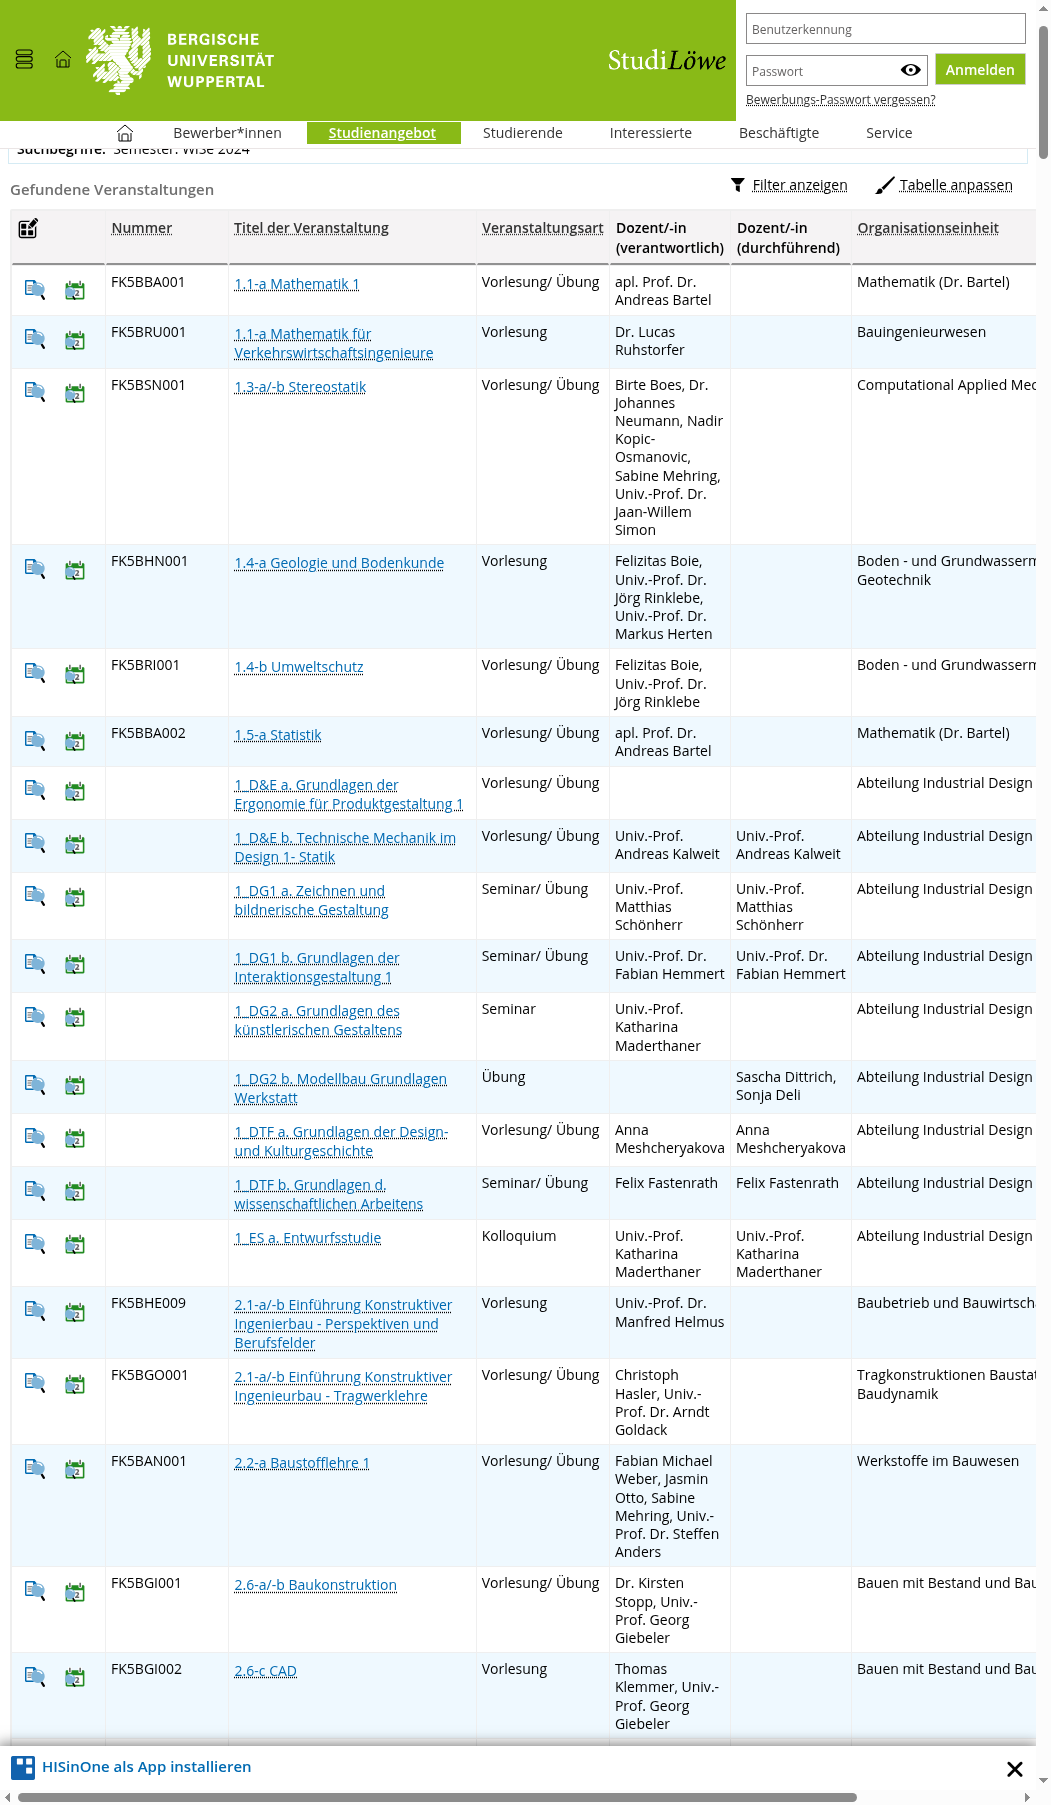

In [5]:
screenshot_fullpage(driver)


In [6]:
# !pip install html5lib

#!pip install lxml html5lib

In [7]:
from bs4 import BeautifulSoup
import pandas as pd
import re
import time
from tqdm.notebook import tqdm  # für Google Colab
from io import StringIO


import time

def click_next_page(driver, css_next_page="#genSearchRes\\:id3f3bd34c5d6b1c79\\:id3f3bd34c5d6b1c79Navi2next", max_attempts=10):
    for attempt in range(1, max_attempts + 1):


        # Seite nach unten scrollen
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(1)

        try:
            weiter_button = driver.find_element(By.CSS_SELECTOR, css_next_page)
            weiter_button.click()
            time.sleep(3)
        except Exception as e:
            continue

        # Prüfe, ob wieder auf der Übersichtsseite (nach erfolgreichem Klick)
        try:
            driver.find_element(By.CSS_SELECTOR, "#genSearchRes\\:genericSearchResult > div.text_white_searchresult > span")
            break
        except:
            continue


def clean_prefixes(df):
    for col in df.columns:
        prefix = str(col).strip()
        df[col] = df[col].astype(str).str.replace(f"^{re.escape(prefix)}", "", regex=True).str.strip()
        df[col] = df[col].replace("nan", pd.NA)
    return df


def scrape_all_pages(driver, css_max_selector, max_pages=None):
    # Seitenanzahl ermitteln
    selector = driver.find_element(By.CSS_SELECTOR, css_max_selector)
    selector_text = selector.text.strip()
    match = re.search(r"\d+$", selector_text)
    if not match:
        raise ValueError("Konnte Seitenzahl nicht extrahieren.")
    select_end = int(match.group())

    if max_pages is not None:
        select_end = min(select_end, max_pages)

    all_tables = []

    for i in tqdm(range(1, select_end + 1), desc="Scraping Seiten", unit="Seite"):
        print(f"\n→ Starte Scraping der Base-Informationen für Seite {i}")

        table_element = driver.find_element(By.CSS_SELECTOR, "#genSearchRes\\:id3f3bd34c5d6b1c79\\:id3f3bd34c5d6b1c79Table")
        table_html = table_element.get_attribute("outerHTML")

        soup = BeautifulSoup(table_html, "html.parser")
        table = pd.read_html(StringIO(str(soup)), header=0, flavor="bs4")[0]
        table = clean_prefixes(table)
        all_tables.append(table)

        click_next_page(driver)
        time.sleep(3)

    return pd.concat(all_tables, ignore_index=True)

In [8]:
css_max_selector = "#genSearchRes\\:id3f3bd34c5d6b1c79\\:id3f3bd34c5d6b1c79Navi2_div > div > span.dataScrollerPageText"
base_info = scrape_all_pages(driver, css_max_selector, max_pages=None)

Scraping Seiten:   0%|          | 0/9 [00:00<?, ?Seite/s]


→ Starte Scraping der Base-Informationen für Seite 1

→ Starte Scraping der Base-Informationen für Seite 2

→ Starte Scraping der Base-Informationen für Seite 3

→ Starte Scraping der Base-Informationen für Seite 4

→ Starte Scraping der Base-Informationen für Seite 5

→ Starte Scraping der Base-Informationen für Seite 6

→ Starte Scraping der Base-Informationen für Seite 7

→ Starte Scraping der Base-Informationen für Seite 8

→ Starte Scraping der Base-Informationen für Seite 9


In [9]:
base_info

,Unnamed: 0,Nummer,Titel der Veranstaltung,Veranstaltungsart,Dozent/-in (verantwortlich),Dozent/-in (durchführend),Organisationseinheit,Aktionen
0,NaN,FK5BBA001,1.1-a Mathematik 1,Vorlesung/ Übung,apl. Prof. Dr. Andreas Bartel,,Mathematik (Dr. Bartel),
1,NaN,FK5BRU001,1.1-a Mathematik für Verkehrswirtschaftsingeni...,Vorlesung,Dr. Lucas Ruhstorfer,,Bauingenieurwesen,
2,NaN,FK5BSN001,1.3-a/-b Stereostatik,Vorlesung/ Übung,"Birte Boes, Dr. Johannes Neumann, Nadir Kopic-...",,Computational Applied Mechanics,
3,NaN,FK5BHN001,1.4-a Geologie und Bodenkunde,Vorlesung,"Felizitas Boie, Univ.-Prof. Dr. Jörg Rinklebe,...",,"Boden - und Grundwassermanagement, Geotechnik",
4,NaN,FK5BRI001,1.4-b Umweltschutz,Vorlesung/ Übung,"Felizitas Boie, Univ.-Prof. Dr. Jörg Rinklebe",,Boden - und Grundwassermanagement,
...,...,...,...,...,...,...,...,...
2638,NaN,KUN032013,Zusätzliches Lehrangebot: Künstlerische Kunstv...,Seminar,Sebastian Bartel-Biet,,Fakultät 8 für Design und Kunst,
2639,NaN,SIC121111,Zuverlässigkeitsplanung,Vorlesung,"Dr. Dirk Althaus, Univ.-Prof. Dr. Stefan Bracke",Dr. Dirk Althaus,Sicherheitstechnik,
2640,NaN,SIC032085,Zuverlässigkeitstechnik in der Industrie 4.0,Vorlesung,Prof. Dr. Antoine Tordeux,Prof. Dr. Antoine Tordeux,Sicherheitstechnik,
2641,NaN,ALT-OPBSOE013,ZZ_alt-LB IfB | LB013: Lernvideos: Arten und G...,E-Learning,"Charlotte Diekmann, Sandra Gerlich","Charlotte Diekmann, Sandra Gerlich","Fakultät 9 - School of Education, L0200 Servic...",


In [10]:


base_info.to_csv('base_info.csv', index=False)

In [16]:

#!pip install pyjanitor

import pandas as pd
import janitor
import re


# Spaltennamen bereinigen und umbenennen
base_info = base_info.clean_names().rename(columns={"titel_der_veranstaltung": "titel"})

# Zeichenbereinigung im Titel
base_info["titel"] = (
    base_info["titel"]
    .str.replace(r"[()|+\-!\".=]", " ", regex=True)
    .str.replace("İ", "", regex=False)
    .str.slice(0, 250)
)

In [17]:
base_info

,unnamed_0,nummer,titel,veranstaltungsart,dozent_in_verantwortlich_,dozent_in_durchfuhrend_,organisationseinheit,aktionen
0,NaN,FK5BBA001,1 1 a Mathematik 1,Vorlesung/ Übung,apl. Prof. Dr. Andreas Bartel,,Mathematik (Dr. Bartel),
1,NaN,FK5BRU001,1 1 a Mathematik für Verkehrswirtschaftsingeni...,Vorlesung,Dr. Lucas Ruhstorfer,,Bauingenieurwesen,
2,NaN,FK5BSN001,1 3 a/ b Stereostatik,Vorlesung/ Übung,"Birte Boes, Dr. Johannes Neumann, Nadir Kopic-...",,Computational Applied Mechanics,
3,NaN,FK5BHN001,1 4 a Geologie und Bodenkunde,Vorlesung,"Felizitas Boie, Univ.-Prof. Dr. Jörg Rinklebe,...",,"Boden - und Grundwassermanagement, Geotechnik",
4,NaN,FK5BRI001,1 4 b Umweltschutz,Vorlesung/ Übung,"Felizitas Boie, Univ.-Prof. Dr. Jörg Rinklebe",,Boden - und Grundwassermanagement,
...,...,...,...,...,...,...,...,...
2638,NaN,KUN032013,Zusätzliches Lehrangebot: Künstlerische Kunstv...,Seminar,Sebastian Bartel-Biet,,Fakultät 8 für Design und Kunst,
2639,NaN,SIC121111,Zuverlässigkeitsplanung,Vorlesung,"Dr. Dirk Althaus, Univ.-Prof. Dr. Stefan Bracke",Dr. Dirk Althaus,Sicherheitstechnik,
2640,NaN,SIC032085,Zuverlässigkeitstechnik in der Industrie 4 0,Vorlesung,Prof. Dr. Antoine Tordeux,Prof. Dr. Antoine Tordeux,Sicherheitstechnik,
2641,NaN,ALT-OPBSOE013,ZZ_alt LB IfB LB013: Lernvideos: Arten und G...,E-Learning,"Charlotte Diekmann, Sandra Gerlich","Charlotte Diekmann, Sandra Gerlich","Fakultät 9 - School of Education, L0200 Servic...",


In [18]:
import os
import time
import pandas as pd
from selenium.webdriver.common.by import By
from tqdm import tqdm

def scrape_missing_data(driver, missing_data, num_sem_selector, file_name):
    total = len(missing_data)
    result_df = pd.DataFrame()

    base_name = file_name.replace(".csv", "")
    counter = 1
    while True:
        new_file_name = f"{base_name}_{counter}.csv"
        if not os.path.exists(new_file_name):
            file_name = new_file_name
            break
        counter += 1

    for i in tqdm(range(total), desc="Scraping Fortschritt"):
        titel = missing_data.iloc[i]['titel']
        nummer = missing_data.iloc[i]['nummer']
        print(f"Starte das Scraping für Titel: '{titel}' (Nummer: {nummer})")

        try:
            driver.find_element(By.CSS_SELECTOR, "#genericSearchMask\\:search_e4ff321960e251186ac57567bec9f4ce\\:cm_exa_eventprocess_basic_data\\:fieldset\\:inputField_3_abb156a1126282e4cf40d48283b4e76d\\:idabb156a1126282e4cf40d48283b4e76d\\:termSelect_label").click()
            time.sleep(2.5)

            css_sem_num = f"#genericSearchMask\\:search_e4ff321960e251186ac57567bec9f4ce\\:cm_exa_eventprocess_basic_data\\:fieldset\\:inputField_3_abb156a1126282e4cf40d48283b4e76d\\:idabb156a1126282e4cf40d48283b4e76d\\:termSelect_{num_sem_selector}"
            driver.find_element(By.CSS_SELECTOR, css_sem_num).click()
            time.sleep(2.5)

            driver.find_element(By.CSS_SELECTOR, "#genericSearchMask\\:buttonsBottom\\:toggleSearchShowAllCriteria").click()
            time.sleep(2.5)

            feld_titel = driver.find_element(By.CSS_SELECTOR, "#genericSearchMask\\:search_e4ff321960e251186ac57567bec9f4ce\\:cm_exa_eventprocess_basic_data\\:fieldset\\:inputField_0_1ad08e26bde39c9e4f1833e56dcce9b5\\:id1ad08e26bde39c9e4f1833e56dcce9b5")
            feld_titel.clear()
            feld_titel.send_keys(titel)

            start_time = time.time()
            ccs_nummer = None
            while time.time() - start_time < 30:
                try:
                    ccs_nummer = driver.find_element(By.CSS_SELECTOR, "#genericSearchMask\\:search_e4ff321960e251186ac57567bec9f4ce\\:cm_exa_eventprocess_basic_data\\:fieldset\\:inputField_2_7cc364bde72c1b1262427dc431caece3\\:id7cc364bde72c1b1262427dc431caece3")
                    break
                except:
                    time.sleep(0.5)
            if not ccs_nummer:
                print("Timeout: CSS-Nummer-Feld nicht gefunden")
                continue
            ccs_nummer.clear()
            ccs_nummer.send_keys(nummer)
            time.sleep(2.5)

            driver.find_element(By.CSS_SELECTOR, "#genericSearchMask\\:buttonsBottom\\:search").click()

            start_time = time.time()
            ccs_find = None
            while time.time() - start_time < 30:
                try:
                    ccs_find = driver.find_element(By.CSS_SELECTOR, "#genSearchRes\\:id3f3bd34c5d6b1c79\\:id3f3bd34c5d6b1c79Table\\:0\\:tableRowAction")
                    break
                except:
                    time.sleep(0.5)
            if not ccs_find:
                print("Timeout: Finden-Button nicht gefunden")
                continue
            ccs_find.click()
            time.sleep(2.5)

            semester = driver.find_element(By.CSS_SELECTOR, "#detailViewData\\:tabContainer\\:term-selection-container\\:termPeriodDropDownList_label").text
            scraping_datum = pd.Timestamp.today().date()

            # Platzhalter für echte Scraping-Funktionen
            termine = {}  # z. B. scrape_termine(driver)
            inhalte = {}  # z. B. scrape_inhalte(driver)
            module = {}   # z. B. scrape_module(driver)
            studiengaenge = {}  # z. B. scrape_studiengaenge(driver)

            row_data = {
                'semester': semester,
                'scraping_datum': scraping_datum,
                'titel': titel,
                'nummer': nummer,
                'termine': termine,
                'inhalte': inhalte,
                'module': module,
                'studiengaenge': studiengaenge
            }
            result_df = pd.concat([result_df, pd.DataFrame([row_data])], ignore_index=True)

            driver.find_element(By.CSS_SELECTOR, "#statusLastLink1").click()
            time.sleep(2.5)

        except Exception as e:
            print(f"Fehler bei Titel '{titel}': {e}")

    result_df.to_csv(file_name, index=False)
    print(f"Daten wurden erfolgreich exportiert nach {file_name}.")
    return result_df

In [24]:
base_url = "https://www.xn--studilwe-s4a.uni-wuppertal.de/qisserver/pages/cm/exa/coursemanagement/basicCourseData.xhtml?_flowId=searchCourseNonStaff-flow&_flowExecutionKey=e3s1"
driver.get(base_url)

# # Scraping starten
# scrape_missing_data(driver, missing_data, num_sem_selector="1", file_name="courses_2024_Winter_Wuppertal.csv")


MaxRetryError: HTTPConnectionPool(host='localhost', port=36041): Max retries exceeded with url: /session/8d1496bf9a17e413561ee45f28636bf7/url (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7c72d1cd5d50>: Failed to establish a new connection: [Errno 111] Connection refused'))